In [77]:
# required to pip install xgboost

In [78]:
#importing libraries
from modules.pca_module import perform_pca
from modules.data_preprocessing import one_hot_encode_categorical
import numpy as np
import pandas as pd
import xgboost as xgb
from numpy import array  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, fbeta_score
from urllib.request import urlretrieve
import glob
from pathlib import Path  # Importing the Path class from the pathlib module
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os 
import math
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [79]:
SEED = 123
def seed_everything(seed=SEED):
    """
    Set the random seed for Python, NumPy, and random module.

    Parameters:
    - seed (int): The seed value to set for randomness. Defaults to 42.

    Returns:
    - None
    """
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)

In [80]:
#GLOBAL VARIABLES
#define percentage of test_split
test_size = 0.2
# Define the programmer whose path you want to use
programmer = 'esther'

#variables for paths names
file_paths_names = {
    'patricia': r"..\original_data",
    'esther': r"C:\Users\egh22\OneDrive - University of Canterbury\bootcamp\group project\data"
}

files_outcome_path_names = {
    'patricia': r"C:\PATRICIA\CODEOP\aaa-PROYECTO COMPARTIDO\ICU-MORTALITY-PREDICTION\original_data\outcomes",
    'esther': r"C:\Users\egh22\OneDrive - University of Canterbury\bootcamp\group project\data\outcomes"
}

#TODO: patricia to add his path properly
files_path_to_save_files = {
    'patricia': r"C:\PATRICIA\CODEOP\aaa-PROYECTO COMPARTIDO\ICU-MORTALITY-PREDICTION",
    'esther': r"C:\Users\egh22\OneDrive - University of Canterbury\bootcamp\group project\clean_data"
}

# Choose the file path based on the programmer variable
file_path_to_save = files_path_to_save_files[programmer]
file_path_to_open = file_path_to_save


### 1. Look at the distribution of the target variable

In [81]:
#loading dataframe for plottin distirbution
knn_df = pd.read_csv(os.path.join(file_path_to_save, 'KNN_imputed_df.csv')) 

In [82]:
# counting positive and negative samples
knn_df['In-hospital_death'].value_counts()
num_pos_samples = knn_df['In-hospital_death'].value_counts()[1]
num_neg_samples  = knn_df['In-hospital_death'].value_counts()[0]
print("Number of positive samples for in hospital death:", num_pos_samples)
print("Number of negative samples for in hospital death:", num_neg_samples)

Number of positive samples for in hospital death: 1122
Number of negative samples for in hospital death: 6878


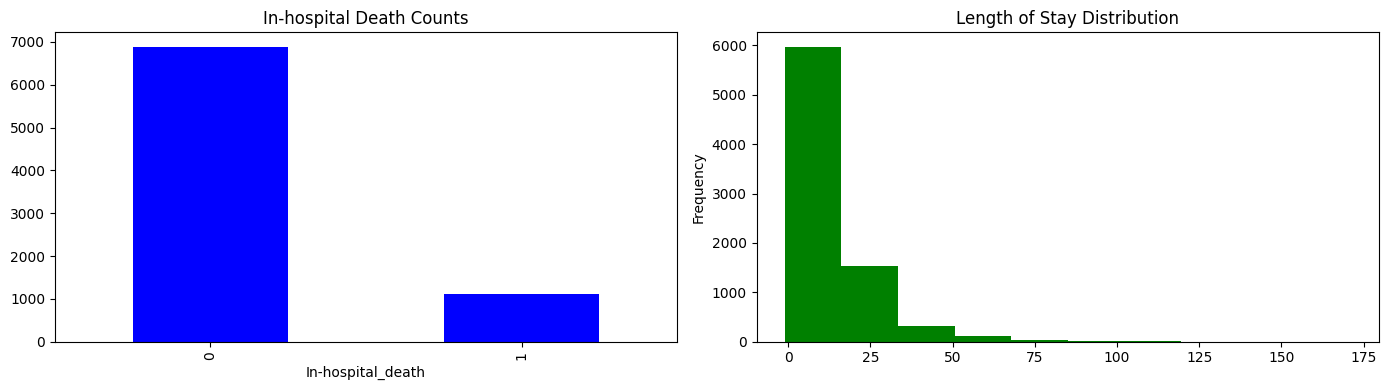

In [83]:
# Create a new figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(14, 4))  # 1 row, 2 columns for two plots

# Plot the count of each value in the 'In-hospital_death' column as a bar plot
knn_df['In-hospital_death'].value_counts().plot(kind="bar", ax=axs[0], color='blue')

# Plot the distribution of values in the 'Length_of_stay' column as a histogram
knn_df['Length_of_stay'].plot(kind="hist", ax=axs[1], color='green')

# Set titles for each subplot
axs[0].set_title('In-hospital Death Counts')
axs[1].set_title('Length of Stay Distribution')

# Show the plots
plt.tight_layout()
plt.show()

## 2. XGBoost Modelling - In Hospital death prediction

<b> Some XGBoost Theory for classification problems </b> </br> </br>
Using XGBClassifier() in combination with RandomizedSearchCV or GridSearchCV is a common approach for hyperparameter tuning and model selection. RandomizedSearchCV, samples from a distribution of parameters, and GridSearchCV evaluates all possible combinations of hyperparameters provided in a grid.

When tuning XGBoost models for classification tasks, there are several important parameters to consider. Here are some of the most crucial ones:

- Learning Rate (eta): The learning rate controls the step size during the gradient descent optimization process. Lower values typically result in slower learning but can lead to better generalization.

- Maximum Depth (max_depth): How deeply a tree is allowed to grow during each boosting round.  Deeper trees can capture more complex patterns in the data but are more prone to overfitting.

- Minimum Child Weight (min_child_weight): This parameter specifies the minimum sum of instance weight needed in a child node. It helps to control overfitting by constraining the partitioning of leaf nodes.

- Subsample:Subsample controls the fraction of training data to be used for each boosting round. If the value is low we can run into underfitting, if the value is very high we may run into overfitting.
  
- Column Subsampling (colsample_bytree or colsample_bylevel): These parameters control the fraction of features (columns) to be used for each tree or each level of trees, respectively during any boosting round. a large value means that almost all features can be used to build a tree during every boosting round. In general a small value can be thought as providing additional regularization to the model, using all columns may overfit a training model. They help introduce diversity into the ensemble and reduce overfitting. As a thumb-rule, square root of the total number of features works great but we should check upto 30-40% of the total number of features.

- Regularization Parameters (lambda, alpha):
Lambda (L2 regularization) and alpha (L1 regularization) control the amount of regularization applied to the weights of the trees. They help prevent overfitting by penalizing large parameter values.

- Number of Trees (num_boost_round):
This parameter specifies the maximum number of boosting rounds (trees) to be trained. Increasing the number of trees can improve performance, but it's essential to monitor for overfitting.

Early Stopping (early_stopping_rounds): Early stopping allows training to stop if the performance on a validation dataset does not improve for a specified number of rounds. It helps prevent overfitting and reduces training time.

Objective Function: The choice of objective function depends on the specific classification problem (e.g., binary classification, multiclass classification). Common options include binary logistic regression (binary classification) and softmax (multiclass classification).

Scale Pos Weight: This parameter is used to balance the positive and negative weights in binary classification tasks with imbalanced class distributions.

A thought on metrics
To evaluate the model I think the best is to us PR AUC (precision-recall curve):
What we are going to use though as a metric is precision and recall, and we will find the minimum of both of them, and this will be our metric as we want both of those metrics to be high

<b> Defining XGboost parameters common for all models </b>

In [84]:
# defining default parameters
cross_validation_folds = 5
early_stopping_rounds = 10
categorical_features = ['Gender', 'ICUType', 'MechVent'] 

#TODO: Do I need this???
# Define the number of folds for cross-validation. 
#kf = KFold(n_splits=cross_validation_folds, shuffle=True, random_state=42)

#define parameter grid
gbm_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma':[1e-5, 1e-2, 0.1, 0.5],
    'reg_alpha':[1e-5, 1e-2, 0.5, 1], #used for high dimensionality
    'reg_lambda':[1e-5, 1e-2, 0.5, 1], #explore for reducing overfitting
    'max_depth': [5, 7, 9],
    'min_child_weight': [1, 5, 15, 200], #NEED HELP ON HOW TOSET UP THIS
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.5, 0.6, 0.7],
    "n_estimators":[100],
    'scale_pos_weight': [np.sqrt(num_neg_samples / num_pos_samples)] #scale_pos_weight is the ratio of number of negative class to the positive class.
}

#grid fixed for first experimenting witht he model
gbm_param_grid_fixed = {
    'learning_rate': [0.1],
    'max_depth': [7],
    'min_child_weight': [100],
    'gamma':[0.01],
    'reg_alpha':[0.3], #used for high dimensionality
    'reg_lambda':[0.3], #explore for reducing overfitting
    'subsample': [0.8],
    'colsample_bytree': [0.7],
    'scale_pos_weight': [1,(num_neg_samples / num_pos_samples), np.sqrt(num_neg_samples / num_pos_samples)] #scale_pos_weight is the ratio of number of negative class to the positive class.
}

# Define parameters, we fix all other parameters and try to find best number of boosting rounds
params_for_boosting_rounds = {
    # Set a large number of boosting rounds initially
    'learning_rate': 0.1,
    'max_depth': 7,
    'min_child_weight': 100,
    'gamma':0.01,
    'reg_alpha':0.3, #used for high dimensionality
    'reg_lambda':0.3, #explore for reducing overfitting
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'scale_pos_weight': np.sqrt(num_neg_samples / num_pos_samples)
}


# define Custom scorer based on f1 score that balances precision and recall
# we can use beta to define wehther we want to penalize recall or precision
fone_scorer = make_scorer(fbeta_score,
                          beta = 1,
                          greater_is_better = True,
                          pos_label = 1)

<b> XGBoost Models performed </b> </br> </br>
We will create a model for:
- KNN imputed dataset without PCA performed
- KNN imputed dataset with PCA performed, assuming variance explained needed of 85%
- Minus 1 imputed dataset without PCA performed
- Minus 1 imputed dataset with PCA performed, assuming variance explained needed of 85%

### 2.1 Using KNN inputed NAN file

In [85]:
#loading dataframe
knn_df = pd.read_csv(os.path.join(file_path_to_save, 'KNN_imputed_df.csv')) 

In [86]:
pd.options.display.max_columns = None
knn_df.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,Creatinine_slope,DiasABP_median,DiasABP_max,DiasABP_mad,DiasABP_last,DiasABP_slope,FiO2_median,FiO2_max,FiO2_mad,FiO2_slope,GCS_median,GCS_mad,GCS_slope,Glucose_48median,Glucose_median,Glucose_max,Glucose_mad,Glucose_slope,HCO3_median,HCO3_mad,HCO3_slope,HCT_median,HCT_mad,HCT_slope,HR_median,HR_max,HR_mad,HR_slope,K_48median,K_median,K_max,K_mad,K_slope,Lactate_median,Lactate_mad,Mg_median,Mg_max,Mg_mad,Mg_slope,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIDiasABP_median,NIDiasABP_max,NIDiasABP_mad,NIDiasABP_last,NIDiasABP_slope,NIMAP_mad,NISysABP_mad,PaCO2_median,PaCO2_max,PaCO2_mad,PaCO2_slope,PaO2_48median,PaO2_median,PaO2_max,PaO2_mad,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,SysABP_median,SysABP_mad,SysABP_last,Temp_48median,Temp_median,Temp_max,Temp_mad,Temp_last,Temp_slope,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Length_of_stay,In-hospital_death
1859,137268.0,34.0,1,3,1152.68435,1,19.0,31.578947,-0.8,0.75,6.666667,-0.006667,58.26625,77.89,8.251045,59.83,-0.29746,0.5,1.0,0.0,0.125,11.5,4.347826,0.015079,122.0,139.5,157.0,12.544803,-2.333333,27.0,7.407407,0.12426,29.3,9.726962,-0.224042,112.5,154.0,8.888889,-0.090177,3.6,4.2,4.2,0.0,-0.039053,2.4,0.0,1.45,1.5,3.448276,0.014286,78.76875,104.5275,7.713041,81.7,0.495492,142.0,0.704225,-0.275148,70.0,129.0,10.0,64.0,0.175015,7.495169,3.846154,40.21875,47.885,6.375298,-0.069615,114.7125,129.42375,234.4025,17.985197,-2.403632,7.380563,0.358511,170.0,18.823529,1.785714,118.77375,7.98267,121.49,37.05,37.3,38.1,0.938338,37.2,-0.001917,140.0,400.0,57.142857,100.0,2.832196,8.7,18.390805,-0.214286,75.0,0.0,20,0


In [87]:
knn_df.shape

(8000, 100)

In [88]:
# Convert the specified columns to categorical type
knn_df[categorical_features] = knn_df[categorical_features].astype("category")

<b> Preparing test-train datasets </b>
- X = training data with all features except target variable 
- y = target variable "In-hospital_death" 
- Drop "Length_of_stay" and use "RecordID"  as index 

In [89]:
# Extract features and target variable
X = knn_df.drop(columns=['In-hospital_death', 'Length_of_stay'])  # Drop the target variable and 'Length_of_stay' column
y = knn_df['In-hospital_death']
# Set 'RecordID' as the index
X.set_index('RecordID', inplace=True)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = \
    train_test_split(
        X, 
        y, 
        test_size= test_size,
        random_state = SEED
    )

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6400, 97)
X_test shape: (1600, 97)
y_train shape: (6400,)
y_test shape: (1600,)


Generating a new scoring function with make_scorer(), using the PR-AUC estimator, Average Precision, on the minority class. 

When your dataset has a significant class imbalance, meaning one class is much more prevalent than the other. In such cases, accuracy might not be a reliable metric because a model could achieve high accuracy by simply predicting the majority class all the time. average_precision_score gives a more nuanced understanding of the model's performance, especially its ability to correctly classify the minority class.

When Precision is Important: average_precision_score considers both precision and recall, but it's particularly useful when you want to emphasize precision. This is often the case in scenarios where the cost of false positives (misclassifying a negative instance as positive) is high

### 2.1.1 XgBooSt performed Without PCA 

<b> Finding the optimal number of boosting rounds </b>

In [90]:
# Create XGBClassifier instance n_jobs =1 use all available resources 
xgb_classifier  = xgb.XGBClassifier(n_jobs=-1, enable_categorical=True,
                                   objective = "binary:logistic",
                                   eval_metric = "aucpr",
                                   early_stopping_rounds=40,
                                   n_estimators = 1000,
                                    **params_for_boosting_rounds)


# Train with early stopping
xgb_classifier.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
# Get the optimal number of boosting rounds
optimal_boosting_rounds = xgb_classifier.best_iteration
print("Optimal number of boosting rounds:", optimal_boosting_rounds)
#optimal boosting rounds is 84

[0]	validation_0-aucpr:0.29463
[1]	validation_0-aucpr:0.42515
[2]	validation_0-aucpr:0.44566
[3]	validation_0-aucpr:0.46053
[4]	validation_0-aucpr:0.48627
[5]	validation_0-aucpr:0.47205
[6]	validation_0-aucpr:0.48203
[7]	validation_0-aucpr:0.48923
[8]	validation_0-aucpr:0.49103
[9]	validation_0-aucpr:0.49200
[10]	validation_0-aucpr:0.49459
[11]	validation_0-aucpr:0.49982
[12]	validation_0-aucpr:0.50727
[13]	validation_0-aucpr:0.51370
[14]	validation_0-aucpr:0.51724
[15]	validation_0-aucpr:0.52036
[16]	validation_0-aucpr:0.52103
[17]	validation_0-aucpr:0.51977
[18]	validation_0-aucpr:0.51782
[19]	validation_0-aucpr:0.52045
[20]	validation_0-aucpr:0.51914
[21]	validation_0-aucpr:0.52216
[22]	validation_0-aucpr:0.52201
[23]	validation_0-aucpr:0.51957
[24]	validation_0-aucpr:0.51893
[25]	validation_0-aucpr:0.51765
[26]	validation_0-aucpr:0.52173
[27]	validation_0-aucpr:0.52739
[28]	validation_0-aucpr:0.53047
[29]	validation_0-aucpr:0.52928
[30]	validation_0-aucpr:0.52960
[31]	validation_0-

<b> Creating GridSearch to find the best parameter combination </b>

In [91]:
gbm_param_grid = gbm_param_grid_fixed

xgb_classifier  = xgb.XGBClassifier(n_jobs=-1, enable_categorical=True,
                                   objective = "binary:logistic",
                                   eval_metric = "aucpr",
                                   n_estimators = optimal_boosting_rounds)


#scoring metric is used during cross-validation and grid search to select the best model
# create grid search to find the best parameter combination
xgb_grid_search = GridSearchCV(estimator = xgb_classifier,
                               param_grid = gbm_param_grid,
                               cv = cross_validation_folds,
                               scoring = fone_scorer,
                               verbose = 1)

# fit all the parameters combination train data using cross-validation to find the best parameter combination
xgb_grid_search.fit(X_train, y_train)

# STORE RESULTS FROM THE PARAMETER COMBINATION
# Convert cv_results_ to a DataFrame
results_df = pd.DataFrame(xgb_grid_search.cv_results_)

# Select relevant columns
relevant_columns = ['params', 'mean_test_score', 'std_test_score']
results_df = results_df[relevant_columns]

# Expand params into separate columns
params_df = pd.DataFrame(results_df['params'].tolist())
results_df = pd.concat([params_df, results_df[['mean_test_score', 'std_test_score']]], axis=1)

# Sort DataFrame by mean_test_score in descending order
results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)
results_df

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,scale_pos_weight,subsample,mean_test_score,std_test_score
1,0.7,0.01,0.1,7,100,0.3,0.3,6.130125,0.8,0.499983,0.017965
2,0.7,0.01,0.1,7,100,0.3,0.3,2.475909,0.8,0.470923,0.032013
0,0.7,0.01,0.1,7,100,0.3,0.3,1.000000,0.8,0.282889,0.033100


<b> Fitting the training data and then predicting on the test with the best parameters found during GridSearch </b> 

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1368
           1       0.43      0.73      0.54       232

    accuracy                           0.82      1600
   macro avg       0.69      0.78      0.71      1600
weighted avg       0.87      0.82      0.84      1600



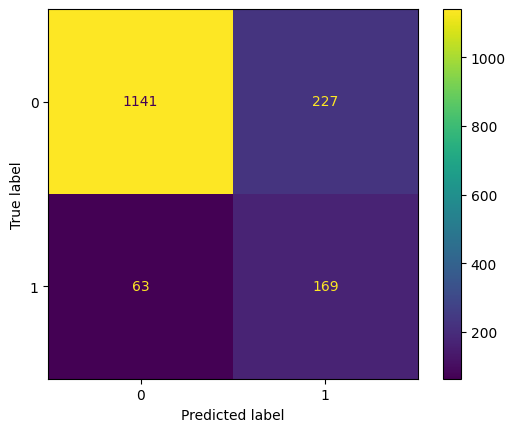

In [92]:
# Get the best parameters from the gridsearch
best_params = xgb_grid_search.best_params_

# Create XGBClassifier with the best parameters
best_xgb_classifier = xgb.XGBClassifier(n_jobs=-1, enable_categorical=True, objective="binary:logistic", eval_metric="aucpr", **best_params)

# Fit the model with the best parameters
best_xgb_classifier.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_xgb_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_xgb_classifier.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb_classifier.classes_).plot()
plt.show()


### 2.1.1 XgBooSt performed With PCA 

<b> Perform PCA </b>

In [93]:
# We need to one-hot encode categorical before performing pca
X_train_encoded = one_hot_encode_categorical(X_train, categorical_features)
X_test_encoded = one_hot_encode_categorical(X_test, categorical_features)

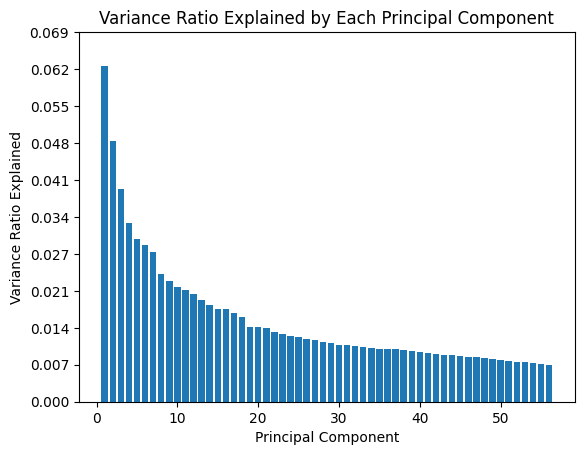

Number of components required to achieve 0.85 variance explained: 56


In [94]:
X_train_PCA, X_test_PCA, pca, explained_variance_ratio = perform_pca (X_train_encoded, X_test_encoded, 0.85)

In [95]:
# Create XGBClassifier instance n_jobs =1 use all available resources 
xgb_classifier  = xgb.XGBClassifier(n_jobs=-1, enable_categorical=True,
                                   objective = "binary:logistic",
                                   eval_metric = "aucpr",
                                   early_stopping_rounds=40,
                                   n_estimators = 1000,
                                    **params_for_boosting_rounds)


# Train with early stopping
xgb_classifier.fit(X_train_PCA, y_train, eval_set=[(X_test_PCA, y_test)], verbose=True)
# Get the optimal number of boosting rounds
optimal_boosting_rounds = xgb_classifier.best_iteration
print("Optimal number of boosting rounds:", optimal_boosting_rounds)
#optimal boosting rounds is 84

[0]	validation_0-aucpr:0.33042
[1]	validation_0-aucpr:0.34396
[2]	validation_0-aucpr:0.35561
[3]	validation_0-aucpr:0.36756
[4]	validation_0-aucpr:0.38462
[5]	validation_0-aucpr:0.38573
[6]	validation_0-aucpr:0.38923
[7]	validation_0-aucpr:0.38869
[8]	validation_0-aucpr:0.39137
[9]	validation_0-aucpr:0.39850
[10]	validation_0-aucpr:0.40463
[11]	validation_0-aucpr:0.40959
[12]	validation_0-aucpr:0.41571
[13]	validation_0-aucpr:0.42697
[14]	validation_0-aucpr:0.42915
[15]	validation_0-aucpr:0.42781
[16]	validation_0-aucpr:0.42095
[17]	validation_0-aucpr:0.42951
[18]	validation_0-aucpr:0.43661
[19]	validation_0-aucpr:0.44208
[20]	validation_0-aucpr:0.44240
[21]	validation_0-aucpr:0.43999
[22]	validation_0-aucpr:0.44114
[23]	validation_0-aucpr:0.44123
[24]	validation_0-aucpr:0.44089
[25]	validation_0-aucpr:0.44413
[26]	validation_0-aucpr:0.44677
[27]	validation_0-aucpr:0.44969
[28]	validation_0-aucpr:0.44804
[29]	validation_0-aucpr:0.45094
[30]	validation_0-aucpr:0.44988
[31]	validation_0-

In [96]:
gbm_param_grid = gbm_param_grid_fixed

xgb_classifier  = xgb.XGBClassifier(n_jobs=-1, enable_categorical=True,
                                   objective = "binary:logistic",
                                   eval_metric = "aucpr",
                                   n_estimators = optimal_boosting_rounds)


#scoring metric is used during cross-validation and grid search to select the best model
# create grid search to find the best parameter combination
xgb_grid_search = GridSearchCV(estimator = xgb_classifier,
                               param_grid = gbm_param_grid,
                               cv = cross_validation_folds,
                               scoring = fone_scorer,
                               verbose = 1)

# fit all the parameters combination train data using cross-validation to find the best parameter combination
xgb_grid_search.fit(X_train_PCA, y_train)

# STORE RESULTS FROM THE PARAMETER COMBINATION
# Convert cv_results_ to a DataFrame
results_df = pd.DataFrame(xgb_grid_search.cv_results_)

# Select relevant columns
relevant_columns = ['params', 'mean_test_score', 'std_test_score']
results_df = results_df[relevant_columns]

# Expand params into separate columns
params_df = pd.DataFrame(results_df['params'].tolist())
results_df = pd.concat([params_df, results_df[['mean_test_score', 'std_test_score']]], axis=1)

# Sort DataFrame by mean_test_score in descending order
results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)
results_df

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,scale_pos_weight,subsample,mean_test_score,std_test_score
1,0.7,0.01,0.1,7,100,0.3,0.3,6.130125,0.8,0.439504,0.025817
2,0.7,0.01,0.1,7,100,0.3,0.3,2.475909,0.8,0.404859,0.042473
0,0.7,0.01,0.1,7,100,0.3,0.3,1.000000,0.8,0.176168,0.040092


<b> Fitting the training data and then predicting on the test with the best parameters found during GridSearch </b> 


              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1368
           1       0.38      0.66      0.48       232

    accuracy                           0.80      1600
   macro avg       0.66      0.74      0.68      1600
weighted avg       0.85      0.80      0.82      1600



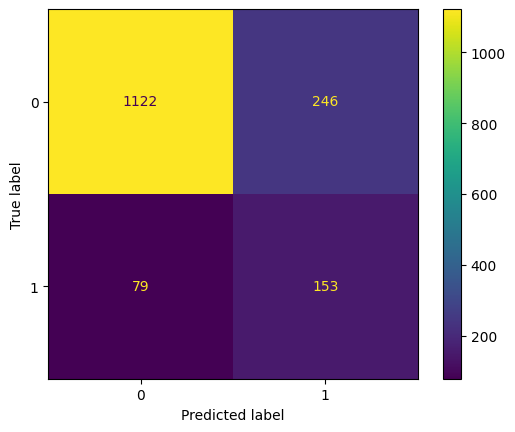

In [97]:
#Get the best parameters from the gridsearch
best_params = xgb_grid_search.best_params_

# Create XGBClassifier with the best parameters
best_xgb_classifier = xgb.XGBClassifier(n_jobs=-1, enable_categorical=True, objective="binary:logistic", eval_metric="aucpr", **best_params)

# Fit the model with the best parameters
best_xgb_classifier.fit(X_train_PCA, y_train)

# Make predictions on test data
y_pred = best_xgb_classifier.predict(X_test_PCA)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_xgb_classifier.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb_classifier.classes_).plot()
plt.show()

###############################################

### 3.1 Using -1 inputed NAN file

In [98]:
#loading dataframe
minus1_df = pd.read_csv(os.path.join(file_path_to_save, 'minus1_imputed_df.csv')) 

In [99]:
pd.options.display.max_columns = None
minus1_df.sample()


,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,Creatinine_slope,DiasABP_median,DiasABP_max,DiasABP_mad,DiasABP_last,DiasABP_slope,FiO2_median,FiO2_max,FiO2_mad,FiO2_slope,GCS_median,GCS_mad,GCS_slope,Glucose_48median,Glucose_median,Glucose_max,Glucose_mad,Glucose_slope,HCO3_median,HCO3_mad,HCO3_slope,HCT_median,HCT_mad,HCT_slope,HR_median,HR_max,HR_mad,HR_slope,K_48median,K_median,K_max,K_mad,K_slope,Lactate_median,Lactate_mad,Mg_median,Mg_max,Mg_mad,Mg_slope,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIDiasABP_median,NIDiasABP_max,NIDiasABP_mad,NIDiasABP_last,NIDiasABP_slope,NIMAP_mad,NISysABP_mad,PaCO2_median,PaCO2_max,PaCO2_mad,PaCO2_slope,PaO2_48median,PaO2_median,PaO2_max,PaO2_mad,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,SysABP_median,SysABP_mad,SysABP_last,Temp_48median,Temp_median,Temp_max,Temp_mad,Temp_last,Temp_slope,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Length_of_stay,In-hospital_death
4101,142915.0,77.0,0,4,32.653061,1,18.5,13.513514,-0.227273,0.7,0.0,-2.939778e-18,65.0,80.0,6.923077,45.0,-0.00551,0.55,0.8,18.181818,-0.040874,8.0,25.0,0.262301,94.0,113.0,132.0,16.814159,-1.727273,24.0,4.166667,0.090909,38.7,1.550388,-0.119214,73.5,100.0,12.244898,-0.706628,4.0,4.0,4.3,7.5,0.027273,1.2,0.0,1.8,2.4,5.555556,0.027273,103.25,125.0,8.474576,76.5,0.089579,134.5,2.60223,0.318182,60.0,60.0,0.0,60.0,-1.0,0.0,0.0,37.5,40.0,1.333333,0.144109,101.0,182.0,292.0,37.087912,-9.149951,7.415,0.067431,194.0,4.639175,-0.866812,169.0,6.804734,140.5,37.0,37.1,38.1,1.617251,36.1,0.004725,140.0,400.0,28.571429,220.0,1.632005,13.2,3.787879,0.031441,81.0,0.0,40,0


In [100]:
minus1_df.shape


(8000, 100)

In [101]:
# Convert the specified columns to categorical type
minus1_df[categorical_features] = minus1_df[categorical_features].astype("category")


<b> Preparing test-train datasets </b>
- X = training data with all features except target variable 
- y = target variable "In-hospital_death" 
- Drop "Length_of_stay" and use "RecordID"  as index 

In [102]:
# Extract features and target variable
X = minus1_df.drop(columns=['In-hospital_death', 'Length_of_stay'])  # Drop the target variable and 'Length_of_stay' column
y = minus1_df['In-hospital_death']
# Set 'RecordID' as the index
X.set_index('RecordID', inplace=True)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = \
    train_test_split(
        X, 
        y, 
        test_size= test_size,
        random_state = SEED
    )

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6400, 97)
X_test shape: (1600, 97)
y_train shape: (6400,)
y_test shape: (1600,)


### 3.1.1 XgBooSt performed Without PCA 

<b> Finding the optimal number of boosting rounds </b>

In [103]:
# Create XGBClassifier instance n_jobs =1 use all available resources 
xgb_classifier  = xgb.XGBClassifier(n_jobs=-1, enable_categorical=True,
                                   objective = "binary:logistic",
                                   eval_metric = "aucpr",
                                   early_stopping_rounds=40,
                                   n_estimators = 1000,
                                    **params_for_boosting_rounds)


# Train with early stopping
xgb_classifier.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
# Get the optimal number of boosting rounds
optimal_boosting_rounds = xgb_classifier.best_iteration
print("Optimal number of boosting rounds:", optimal_boosting_rounds)
#optimal boosting rounds is 84

[0]	validation_0-aucpr:0.32102
[1]	validation_0-aucpr:0.38415
[2]	validation_0-aucpr:0.40951
[3]	validation_0-aucpr:0.42715
[4]	validation_0-aucpr:0.44281
[5]	validation_0-aucpr:0.45665
[6]	validation_0-aucpr:0.45632
[7]	validation_0-aucpr:0.47176
[8]	validation_0-aucpr:0.46759
[9]	validation_0-aucpr:0.47663
[10]	validation_0-aucpr:0.48854
[11]	validation_0-aucpr:0.49046
[12]	validation_0-aucpr:0.49380
[13]	validation_0-aucpr:0.49894
[14]	validation_0-aucpr:0.51327
[15]	validation_0-aucpr:0.51706
[16]	validation_0-aucpr:0.52972
[17]	validation_0-aucpr:0.53024
[18]	validation_0-aucpr:0.53608
[19]	validation_0-aucpr:0.53701
[20]	validation_0-aucpr:0.54389
[21]	validation_0-aucpr:0.54608
[22]	validation_0-aucpr:0.54766
[23]	validation_0-aucpr:0.54687
[24]	validation_0-aucpr:0.54566
[25]	validation_0-aucpr:0.54313
[26]	validation_0-aucpr:0.54557
[27]	validation_0-aucpr:0.54550
[28]	validation_0-aucpr:0.54777
[29]	validation_0-aucpr:0.54973
[30]	validation_0-aucpr:0.54612
[31]	validation_0-

<b> Creating GridSearch to find the best parameter combination </b>

In [104]:
gbm_param_grid = gbm_param_grid_fixed

xgb_classifier  = xgb.XGBClassifier(n_jobs=-1, enable_categorical=True,
                                   objective = "binary:logistic",
                                   eval_metric = "aucpr",
                                   n_estimators = optimal_boosting_rounds)


#scoring metric is used during cross-validation and grid search to select the best model
# create grid search to find the best parameter combination
xgb_grid_search = GridSearchCV(estimator = xgb_classifier,
                               param_grid = gbm_param_grid,
                               cv = cross_validation_folds,
                               scoring = fone_scorer,
                               verbose = 1)

# fit all the parameters combination train data using cross-validation to find the best parameter combination
xgb_grid_search.fit(X_train, y_train)

# STORE RESULTS FROM THE PARAMETER COMBINATION
# Convert cv_results_ to a DataFrame
results_df = pd.DataFrame(xgb_grid_search.cv_results_)

# Select relevant columns
relevant_columns = ['params', 'mean_test_score', 'std_test_score']
results_df = results_df[relevant_columns]

# Expand params into separate columns
params_df = pd.DataFrame(results_df['params'].tolist())
results_df = pd.concat([params_df, results_df[['mean_test_score', 'std_test_score']]], axis=1)

# Sort DataFrame by mean_test_score in descending order
results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)
results_df

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,scale_pos_weight,subsample,mean_test_score,std_test_score
1,0.7,0.01,0.1,7,100,0.3,0.3,6.130125,0.8,0.485691,0.015402
2,0.7,0.01,0.1,7,100,0.3,0.3,2.475909,0.8,0.469068,0.026118
0,0.7,0.01,0.1,7,100,0.3,0.3,1.000000,0.8,0.219702,0.040631


<b> Fitting the training data and then predicting on the test with the best parameters found during GridSearch </b> 

              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1368
           1       0.43      0.74      0.55       232

    accuracy                           0.82      1600
   macro avg       0.69      0.79      0.72      1600
weighted avg       0.87      0.82      0.84      1600



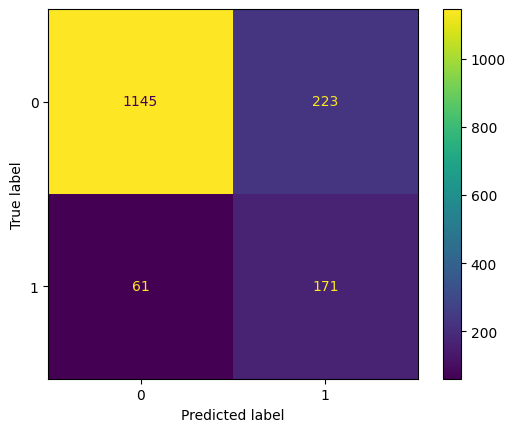

In [105]:
# Get the best parameters from the gridsearch
best_params = xgb_grid_search.best_params_

# Create XGBClassifier with the best parameters
best_xgb_classifier = xgb.XGBClassifier(n_jobs=-1, enable_categorical=True, objective="binary:logistic", eval_metric="aucpr", **best_params)

# Fit the model with the best parameters
best_xgb_classifier.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_xgb_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_xgb_classifier.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb_classifier.classes_).plot()
plt.show()


### 2.1.1 XgBooSt performed With PCA 

<b> Perform PCA </b>

In [106]:
# We need to one-hot encode categorical before performing pca
X_train_encoded = one_hot_encode_categorical(X_train, categorical_features)
X_test_encoded = one_hot_encode_categorical(X_test, categorical_features)

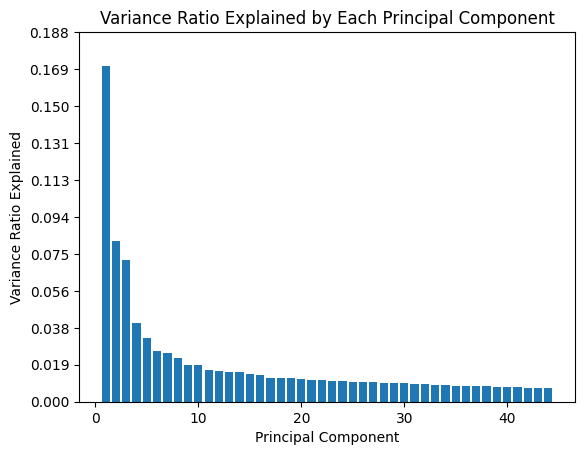

Number of components required to achieve 0.85 variance explained: 44


In [107]:
X_train_PCA, X_test_PCA, pca, explained_variance_ratio = perform_pca (X_train_encoded, X_test_encoded, 0.85)

In [108]:
# Create XGBClassifier instance n_jobs =1 use all available resources 
xgb_classifier  = xgb.XGBClassifier(n_jobs=-1, enable_categorical=True,
                                   objective = "binary:logistic",
                                   eval_metric = "aucpr",
                                   early_stopping_rounds=40,
                                   n_estimators = 1000,
                                    **params_for_boosting_rounds)


# Train with early stopping
xgb_classifier.fit(X_train_PCA, y_train, eval_set=[(X_test_PCA, y_test)], verbose=True)
# Get the optimal number of boosting rounds
optimal_boosting_rounds = xgb_classifier.best_iteration
print("Optimal number of boosting rounds:", optimal_boosting_rounds)
#optimal boosting rounds is 84

[0]	validation_0-aucpr:0.28928
[1]	validation_0-aucpr:0.30046
[2]	validation_0-aucpr:0.31112
[3]	validation_0-aucpr:0.33047
[4]	validation_0-aucpr:0.33452
[5]	validation_0-aucpr:0.34564
[6]	validation_0-aucpr:0.35466
[7]	validation_0-aucpr:0.35241
[8]	validation_0-aucpr:0.36659
[9]	validation_0-aucpr:0.37017
[10]	validation_0-aucpr:0.37354
[11]	validation_0-aucpr:0.37807
[12]	validation_0-aucpr:0.38482
[13]	validation_0-aucpr:0.38691
[14]	validation_0-aucpr:0.38550
[15]	validation_0-aucpr:0.38985
[16]	validation_0-aucpr:0.38809
[17]	validation_0-aucpr:0.39059
[18]	validation_0-aucpr:0.39121
[19]	validation_0-aucpr:0.39191
[20]	validation_0-aucpr:0.39512
[21]	validation_0-aucpr:0.39619
[22]	validation_0-aucpr:0.39823
[23]	validation_0-aucpr:0.40291
[24]	validation_0-aucpr:0.40374
[25]	validation_0-aucpr:0.40892
[26]	validation_0-aucpr:0.41033
[27]	validation_0-aucpr:0.40895
[28]	validation_0-aucpr:0.41035
[29]	validation_0-aucpr:0.40886
[30]	validation_0-aucpr:0.41413
[31]	validation_0-

In [109]:
gbm_param_grid = gbm_param_grid_fixed

xgb_classifier  = xgb.XGBClassifier(n_jobs=-1, enable_categorical=True,
                                   objective = "binary:logistic",
                                   eval_metric = "aucpr",
                                   n_estimators = optimal_boosting_rounds)


#scoring metric is used during cross-validation and grid search to select the best model
# create grid search to find the best parameter combination
xgb_grid_search = GridSearchCV(estimator = xgb_classifier,
                               param_grid = gbm_param_grid,
                               cv = cross_validation_folds,
                               scoring = fone_scorer,
                               verbose = 1)

# fit all the parameters combination train data using cross-validation to find the best parameter combination
xgb_grid_search.fit(X_train_PCA, y_train)

# STORE RESULTS FROM THE PARAMETER COMBINATION
# Convert cv_results_ to a DataFrame
results_df = pd.DataFrame(xgb_grid_search.cv_results_)

# Select relevant columns
relevant_columns = ['params', 'mean_test_score', 'std_test_score']
results_df = results_df[relevant_columns]

# Expand params into separate columns
params_df = pd.DataFrame(results_df['params'].tolist())
results_df = pd.concat([params_df, results_df[['mean_test_score', 'std_test_score']]], axis=1)

# Sort DataFrame by mean_test_score in descending order
results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)
results_df

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,scale_pos_weight,subsample,mean_test_score,std_test_score
1,0.7,0.01,0.1,7,100,0.3,0.3,6.130125,0.8,0.424448,0.022491
2,0.7,0.01,0.1,7,100,0.3,0.3,2.475909,0.8,0.389498,0.037097
0,0.7,0.01,0.1,7,100,0.3,0.3,1.000000,0.8,0.157688,0.028389


<b> Fitting the training data and then predicting on the test with the best parameters found during GridSearch </b> 


              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1368
           1       0.38      0.65      0.48       232

    accuracy                           0.79      1600
   macro avg       0.66      0.73      0.68      1600
weighted avg       0.85      0.79      0.81      1600



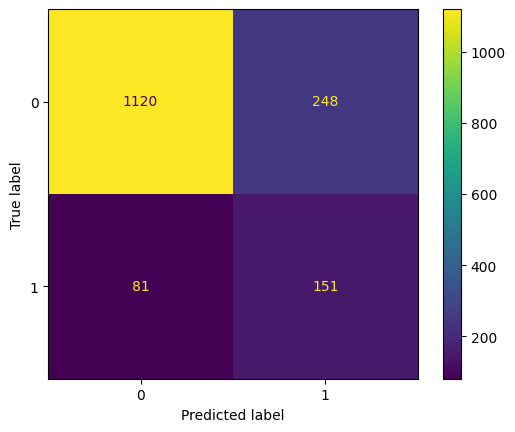

In [110]:
#Get the best parameters from the gridsearch
best_params = xgb_grid_search.best_params_

# Create XGBClassifier with the best parameters
best_xgb_classifier = xgb.XGBClassifier(n_jobs=-1, enable_categorical=True, objective="binary:logistic", eval_metric="aucpr", **best_params)

# Fit the model with the best parameters
best_xgb_classifier.fit(X_train_PCA, y_train)

# Make predictions on test data
y_pred = best_xgb_classifier.predict(X_test_PCA)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_xgb_classifier.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb_classifier.classes_).plot()
plt.show()